# Probabilistic Traffic Engineering with ORBIT + Repetita

This notebook shows how to:

1. Take a **real network topology + traffic matrix** from the **Repetita** dataset.
2. Map it to a **probabilistic optimisation model** suitable for the ORBIT simulator.
3. Run the ORBIT simulator to obtain routing configurations.
4. Compare against a simple classical baseline.
5. Discuss how this could show **hardware advantage** (latency / quality / energy) at scale.


In [1]:
import sys, os

# Add the project root (one level up) to the Python path
sys.path.append(os.path.abspath('..'))

In [2]:
# === Basic imports ===
from pathlib import Path
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import orbit


plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True


# === Repetita paths ===
# Point this to wherever you cloned / unpacked Repetita
REPETITA_ROOT = Path("/home/adam/qd/Repetita")

# You’ll likely want to pick a small-ish topology.
# These filenames are examples / placeholders; adjust once you browse data/.
TOPOLOGY_FILE = REPETITA_ROOT / "data/2016TopologyZooUCL_unary/Abilene.graph"  
DEMAND_FILE   = REPETITA_ROOT / "data/2016TopologyZooUCL_unary/Abilene.0000.demands"  
REPETITA_ROOT, TOPOLOGY_FILE, DEMAND_FILE


(PosixPath('/home/adam/qd/Repetita'),
 PosixPath('/home/adam/qd/Repetita/data/2016TopologyZooUCL_unary/Abilene.graph'),
 PosixPath('/home/adam/qd/Repetita/data/2016TopologyZooUCL_unary/Abilene.0000.demands'))

## Understanding the Repetita Topology & Demand Files

We are using the **Abilene** network from the Repetita dataset.

### Topology File (`Abilene.graph`)

The head of the file shows:

```
NODES 11
label x y
0_New_York -74.00597 40.71427
1_Chicago -87.65005 41.85003
```

This means:

- The network has **11 nodes**.
- Each node line has:
  - A `label` combining an ID and city name (e.g., `0_New_York`).
  - Geographic coordinates (`x`, `y`) which we won’t use for routing but are useful for plotting.

Then:

```
EDGES 28
label src dest weight bw delay
edge_0 0 1 1 9953280 1913
edge_1 1 0 1 9953280 1913
```


This means:

- There are **28 directed edges**.
- Each edge entry includes:
  - `src`, `dest`: endpoint node IDs.
  - `weight`: typically a link cost (e.g., for shortest-path routing).
  - `bw`: the link **capacity** in Kbit/s.
  - `delay`: link latency (in µs or ms depending on dataset).

We will use:
- `capacity` → to evaluate congestion,
- `delay` or `weight` → for shortest path baselines,
- connectivity → to define allowable routing.

---

### Demand File (`Abilene.0000.demands`)

The head:

```
DEMANDS 110
label src dest bw
demand_14 1 5 30036
demand_15 1 6 13153
```

This means:

- There are **110 traffic demands**.
- Each demand specifies:
  - `src`, `dst`: source and destination nodes,
  - `bw`: the **traffic volume** (e.g., in Kbit/s).

Together, these define the **Traffic Matrix** for the network.

We will use:
- Each `(src, dest, bw)` tuple as a flow that must be routed through the topology.
- The goal: find routing decisions that **minimise congestion** (e.g., maximum link utilisation).


In [3]:
print("=== Topology file head ===")
with open(TOPOLOGY_FILE) as f:
    for _ in range(20):
        line = f.readline()
        if not line:
            break
        print(line.rstrip())

print("\n=== Demand file head ===")
with open(DEMAND_FILE) as f:
    for _ in range(20):
        line = f.readline()
        if not line:
            break
        print(line.rstrip())


=== Topology file head ===
NODES 11
label x y
0_New_York -74.00597 40.71427
1_Chicago -87.65005 41.85003
2_Washington_DC -77.03637 38.89511
3_Seattle -122.33207 47.60621
4_Sunnyvale -122.03635 37.36883
5_Los_Angeles -118.24368 34.05223
6_Denver -104.9847 39.73915
7_Kansas_City -94.62746 39.11417
8_Houston -95.36327 29.76328
9_Atlanta -84.38798 33.749
10_Indianapolis -86.15804 39.76838

EDGES 28
label src dest weight bw delay
edge_0 0 1 1 9953280 1913
edge_1 1 0 1 9953280 1913
edge_2 0 2 1 9953280 552
edge_3 2 0 1 9953280 552

=== Demand file head ===
DEMANDS 110
label src dest bw
demand_0 0 1 193388
demand_1 0 2 84913
demand_2 0 3 231404
demand_3 0 4 284378
demand_4 0 5 117503
demand_5 0 6 51458
demand_6 0 7 379460
demand_7 0 8 30063
demand_8 0 9 111296
demand_9 0 10 162652
demand_10 1 0 68076
demand_11 1 2 21705
demand_12 1 3 59153
demand_13 1 4 72694
demand_14 1 5 30036
demand_15 1 6 13153
demand_16 1 7 96999
demand_17 1 8 7684


In [4]:
from helpers.load_topology import load_repetita_topology

G = load_repetita_topology(TOPOLOGY_FILE)
print(f"Loaded topology with {G.number_of_nodes()} nodes and {G.number_of_edges()} directed edges.")
list(G.nodes(data=True))[:3], list(G.edges(data=True))[:3]


Loaded topology with 11 nodes and 28 directed edges.


([(0, {'label': '0_New_York', 'x': -74.00597, 'y': 40.71427}),
  (1, {'label': '1_Chicago', 'x': -87.65005, 'y': 41.85003}),
  (2, {'label': '2_Washington_DC', 'x': -77.03637, 'y': 38.89511})],
 [(0,
   1,
   {'label': 'edge_0', 'weight': 1.0, 'capacity': 9953280.0, 'delay': 1913.0}),
  (0,
   2,
   {'label': 'edge_2', 'weight': 1.0, 'capacity': 9953280.0, 'delay': 552.0}),
  (1,
   0,
   {'label': 'edge_1',
    'weight': 1.0,
    'capacity': 9953280.0,
    'delay': 1913.0})])

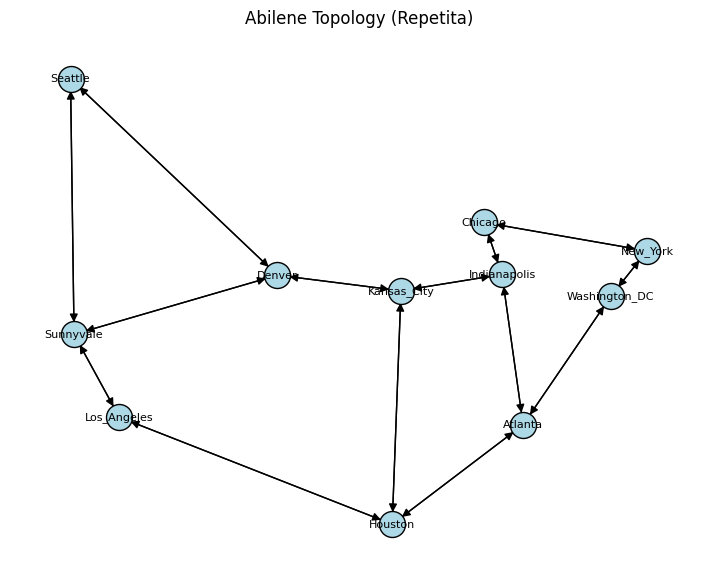

In [5]:
from helpers.plot_topology import plot_repetita_topology

plot_repetita_topology(G, "Abilene Topology (Repetita)")

In [6]:
from helpers.load_demands import load_repetita_demands

demands_df = load_repetita_demands(DEMAND_FILE)
print(demands_df.shape)
demands_df.head()


(110, 4)


,label,src,dst,bw
0,demand_0,0,1,193388.0
1,demand_1,0,2,84913.0
2,demand_2,0,3,231404.0
3,demand_3,0,4,284378.0
4,demand_4,0,5,117503.0


## Baseline Routing and Maximum Link Utilisation (MLU)

Before applying the ORBIT probabilistic optimiser, we need a simple classical
reference point. In this section, we evaluate the network using **standard
shortest-path routing**, similar to what an OSPF-style protocol would produce.

### What we did
- We loaded a real topology (Abilene) and traffic matrix from the **Repetita**
  dataset.
- For each demand (source → destination with a required bandwidth), we routed
  all traffic along the **single shortest path** based on the `delay` metric
  stored in the topology file.
- We then aggregated the traffic on each directed edge.
- For each edge, we computed **link utilisation**:

\[
\text{utilisation}(u,v) = \frac{\text{load}(u,v)}{\text{capacity}(u,v)}
\]

- The **Maximum Link Utilisation (MLU)** is simply the highest utilisation
  across all edges.

### Why this baseline matters
Shortest-path routing is:
- simple,
- deterministic,
- widely used in practice,
- but **not traffic-aware**.

It often produces imbalanced load where some links are congested while others
remain under-utilised.  
This makes it a perfect baseline for evaluating improved routing techniques.

### Interpretation of the result
We obtained:

- **MLU ≈ 1.66**

This means at least one link is carrying **166% of its capacity**, i.e. the
network is **overloaded** under shortest-path routing.

This creates a meaningful optimisation target for the ORBIT model:  
find alternative routing configurations (via probabilistic sampling) that
**reduce MLU** by spreading traffic more intelligently across the network.


In [15]:
from helpers.mlu_shortest_routing import compute_shortest_path_routing, compute_mlu

baseline_loads = compute_shortest_path_routing(G, demands_df, weight_attr="delay")
baseline_mlu = compute_mlu(G, baseline_loads)

print(f"Number of edges carrying traffic: {len(baseline_loads)}")
print(f"Baseline MLU (shortest-path routing): {baseline_mlu:.4f}")

Number of edges carrying traffic: 28
Baseline MLU (shortest-path routing): 1.6593
